In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re

In [2]:
import EpDDM2

In [3]:
import sys
import os
tornado_path = os.path.abspath('../tornado')
sys.path.insert(0, tornado_path)

In [4]:
from data_structures.attribute_scheme import AttributeScheme
from classifier.__init__ import *
from drift_detection.__init__ import *
from filters.project_creator import Project
from graphic.hex_colors import Color
from streams.readers.arff_reader import ARFFReader
from tasks.prequential_learner_detector_pairs import PrequentialMultiPairs

In [351]:
plt.style.use('ggplot')

In [48]:
from importlib import reload
EpDDM2 = reload(EpDDM2)

In [49]:
CDDM = EpDDM2.EpDDM

In [56]:
def generate_data(n_samples, p, rate=0.5):
    # p = [ Pr(y=1|x=0), Pr(y=1|x=1) ]
    # rate is proportion of x=1 (rather than x=0)
    x = np.array([ np.random.choice(2, p=[1-rate, rate]) for i in range(n_samples) ])
    y = [ np.random.choice(2, p=[1-p[i], p[i]]) for i in x ]
    x = x.reshape(-1, 1)

    return x, y

class Experiment:
    
    pre_drift_n = 1000
    post_drift_n = 1000
    
    def __init__(self, probs, detector, model, rates, parameter=None):
        # probs = [a,b,c,d]
        # Before drift:
        # P(1|0) = a
        # P(1|1) = b
        # After drift:
        # P(1|0) = c
        # P(1|1) = d
        self.probs = probs
        self.detector = detector
        self.model = model
        self.result = None
        self.rates = rates
        self.parameter = parameter
        
    def run_experiment(self):
        x1, y1 = generate_data(Experiment.pre_drift_n, self.probs[:2], self.rates[0])
        x2, y2 = generate_data(Experiment.post_drift_n, self.probs[2:], self.rates[1])
        # return either none or the point of detection
        model = self.model
        if type(model)==str:
            model = eval(model)()
        detector = self.detector
        if type(detector)==str:
            detector = eval(detector)()
        monitor = []
        # Calibrate the detector
        for i in range(len(x1)):
            y_ = y1[i: i+1]
            x_ = x1[i: i+1]
            model.partial_fit(x_, y_, classes=[0,1])
            
            if type(detector)==EpDDM2.EpDDM:
                proba = model.predict_proba(x_)
                args = [proba, y_]
                try:
                    monitor.append(min(detector.hoeffding_bounds))
                except:
                    monitor.append(None)
            else:
                pred = model.predict([x_])
#                 print(pred, x_[0])
                pr = pred==y_
                args = [pr]
                monitor.append(pr)
                
            warning_status, drift_status = detector.detect(*args)
#         print(monitor)
#         print(detector.drift_threshold)
#         print('err rate', np.mean(np.array(prs).flatten()))
        monitor = []
        for i in range(len(x2)):
            y_ = y2[i: i+1]
            x_ = x2[i: i+1]
            
            if type(detector)==EpDDM2.EpDDM:
                proba = model.predict_proba(x_)
                args = [proba, y_]
                try:
                    monitor.append(min(detector.hoeffding_bounds))
                except:
                    monitor.append(None)
            else:
                pred = model.predict([x_])
#                 print(pred, /y_)
                pr = pred==y_
                args = [pr]
                monitor.append(pr)
                
            warning_status, drift_status = detector.detect(*args)
            
            if drift_status:
                self.result = i+1
#                 print('detected drift at', i)
                return i
#         print(monitor)
            
            # TODO: partial_fit model?
            
#            print(i, y_, x_, self.result)
        
        return
    
    def get_result_row(self):
        return pd.DataFrame({'Experiment': [f'{self.detector} + {self.model}'],
                            'Outcome': [self.result],
                           'Parameter': [self.parameter]})
    
class RepeatedExperiment:
    
    n_repeats = 1
    
    def __init__(self, probs, detector, model, rates):
        
        self.experiments = []
        self.detector = detector
        self.probs = probs
        self.model = model
        self.rates = rates
        
    def run_experiments(self):
#         print(self.detector, '\n\n')
        for i in range(RepeatedExperiment.n_repeats):
            new_experiment = Experiment(self.probs, self.detector, self.model, self.rates)
            new_experiment.run_experiment()
            self.experiments.append(new_experiment)
        
    def get_summary(self):
        results = [ exp.result for exp in self.experiments ]
        detections = [ i for i in results if i ]
        latency = np.mean(detections)
        try:
            recall = len(detections) / len(results)
        except:
            recall = 0
#         print(results)
        return {'latency': latency, 
                'detection_rate': recall }
    
class MultiDetectorExperiments:
    
    def __init__(self, probs, detectors, models, rates=[0.5, 0.5]):
        self.probs = probs
        self.detectors = detectors
        self.models = models
        self.repeated_experiments = {}
        self.rates = rates
        
    def run_experiments(self):
        for detector in self.detectors:
            for model in self.models:
                new_experiments = RepeatedExperiment(self.probs, eval(detector), eval(model), self.rates)
                new_experiments.run_experiments()
                name = f'{model} + {detector}'
                self.repeated_experiments[name] = new_experiments
        
    def results_table(self):
        table = pd.DataFrame(columns=['Experiment', 'Latency', 'Detection Rate'])
        i = 0
        for (name, repeated_experiment) in self.repeated_experiments.items():
            summary = repeated_experiment.get_summary()
            latency, detection_rate = summary['latency'], summary['detection_rate']
            table.loc[i] = [name, latency, detection_rate]
            
#             results = [ exp.result for exp in repeated_experiment.experiments ]
#             detections = [ i for i in results if i ]
#             print(detections)
#             latency = np.mean(detections)
            
            i += 1
        return table

In [289]:
class NB: # Naive Bayes
    def __init__(self):
        self.counts = { 0: np.array([1,1]), 1: np.array([1,1])}
    def partial_fit(self, x, y, classes=None):
        for x_, y_ in zip(x, y):
            self.counts[x_[0]][y_] += 1
        return self
    def predict_proba(self, x):
        ret = []
        for x_ in x:
#             x_ = x_[0]
            while not type(x_)==np.int64 and not type(x_)==int:
                x_ = x_[0]
            ret.append( self.counts[x_]/np.sum(self.counts[x_]) )
        ret = np.array(ret)
        return ret
    def predict(self, x):
        probs = self.predict_proba(x)
        ret = [ max([0,1], key=lambda x: line[x]) for line in probs ]
        return ret

In [293]:
detectors = ['CDDM', 'HDDM_A_test', 'RDDM']
models = ['NB']

def experiment(probs, rates, param=None, repeats=10):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for i in range(repeats):
        for detector in detectors:
            for model in models:
                exp = Experiment(probs, detector, model, rates, param)
                exp.run_experiment()
                results = results.append(exp.get_result_row())
    return results

# Detection Delay, High Confidence

In [249]:
def delay_experiment(epsilon):
    probs = [1-epsilon, epsilon, epsilon, 1-epsilon]
    rates = [0.5, 0.5]
    return experiment(probs, rates, param=epsilon)

def latency_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.3, num=10):
        results = results.append(delay_experiment(epsilon))
    return results

latency = latency_experiments()

In [334]:
latency

,Experiment,Outcome,Parameter
0,CDDM + NB,19,0.0
0,HDDM_A_test + NB,4,0.0
0,RDDM + NB,1,0.0
0,CDDM + NB,19,0.0
0,HDDM_A_test + NB,4,0.0
0,RDDM + NB,1,0.0
0,CDDM + NB,19,0.0
0,HDDM_A_test + NB,4,0.0
0,RDDM + NB,1,0.0
0,CDDM + NB,19,0.0


In [307]:
# Tidy data so that seaborn will accept it
latency_ = latency[~(latency['Outcome'].isna())]
latency_['Outcome'] = latency_['Outcome'].astype('int')
latency_['Experiment'] = latency_['Experiment'].astype('category')

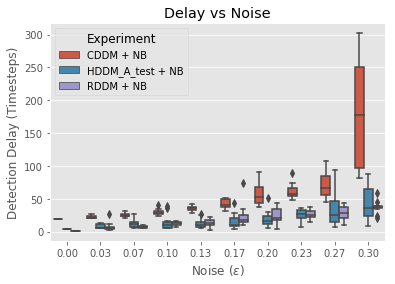

In [354]:
# Create plot
g = sns.boxplot(x='Parameter', y='Outcome', hue='Experiment', data=latency_)
g.set(xlabel='Noise ($\epsilon$)', ylabel='Detection Delay (Timesteps)', title='Delay vs Noise');

# Fix the ticks
tick_labs = [ f'{float(i.get_text()):.2f}' for i in g.get_xticklabels()]#[::2] ]
g.set_xticklabels(tick_labs);
plt.savefig('delay_noise_plt.png')

# False Positives vs Noise

In [327]:
def high_noise_experiment(epsilon):
    probs = [0.5-epsilon, 0.5+epsilon, 0.5-epsilon, 0.5+epsilon]
    rates = [0.5, 0.5]
    return experiment(probs, rates, param=epsilon, repeats=20)

def high_noise_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.5, num=20):
        results = results.append(high_noise_experiment(epsilon))
    return results

high_noise = high_noise_experiments()

In [329]:
def get_fp_df(results):
    experiments = list(results.Experiment.unique())
    fp_df = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    i = 1
    for exp in results.Experiment.unique():
        for param in results.Parameter.unique():
            hn_i = results[(results.Experiment==exp) & (results.Parameter==param)]
            positives = [ i for i in hn_i.Outcome if i!=None]
            fp_df.loc[i, :] = [exp, param, len(positives)/len(hn_i)]
            i += 1
    fp_df['Experiment'] = fp_df['Experiment'].astype('category')
    fp_df['Parameter'] = fp_df['Parameter'].astype('float')
    fp_df['Outcome'] = fp_df['Outcome'].astype('float')
    return fp_df

In [330]:
high_noise_ = get_fp_df(high_noise)

In [335]:
high_noise_

,Experiment,Outcome,Parameter
0,CDDM + NB,None,0.0
0,HDDM_A_test + NB,None,0.0
0,RDDM + NB,596,0.0
0,CDDM + NB,None,0.0
0,HDDM_A_test + NB,None,0.0
0,RDDM + NB,None,0.0
0,CDDM + NB,None,0.0
0,HDDM_A_test + NB,None,0.0
0,RDDM + NB,None,0.0
0,CDDM + NB,None,0.0


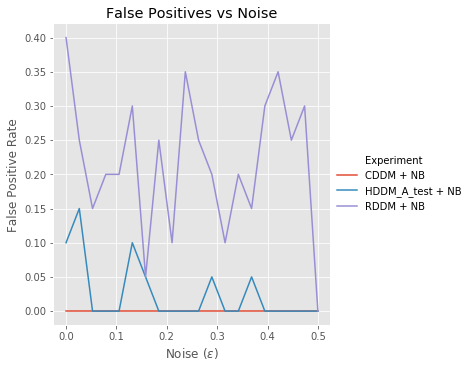

In [355]:
# Create plot
g = sns.relplot(x='Parameter', y='Outcome', hue='Experiment', kind='line', data=high_noise_)
g.set(xlabel='Noise ($\epsilon$)', ylabel='False Positive Rate', title='False Positives vs Noise');
plt.savefig('noise_fp_plt.png')

# Fix the ticks
# tick_labs = [ f'{float(i.get_text()):.2f}' for i in g.get_xticklabels()]
# g.set_xticklabels(tick_labs);

# Virtual Drift False Positives

In [340]:
def vd_experiment(epsilon):
    probs = [1, 0.5, 1, 0.5]
    rates = [0.5-epsilon, 0.5+epsilon]
    return experiment(probs, rates, param=epsilon, repeats=20)

def vd_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.49, num=10):
        results = results.append(vd_experiment(epsilon))
    return results

vd_df = vd_experiments()

In [341]:
vd_fps = get_fp_df(vd_df)
vd_fps

,Experiment,Parameter,Outcome
1,CDDM + NB,0.000000,0.00
2,CDDM + NB,0.054444,0.00
3,CDDM + NB,0.108889,0.00
4,CDDM + NB,0.163333,0.00
5,CDDM + NB,0.217778,0.00
6,CDDM + NB,0.272222,0.00
7,CDDM + NB,0.326667,0.00
8,CDDM + NB,0.381111,0.00
9,CDDM + NB,0.435556,0.00
10,CDDM + NB,0.490000,0.05


In [ ]:
vd_fps['Parameter'] = vd_fps['Parameter'] * 2

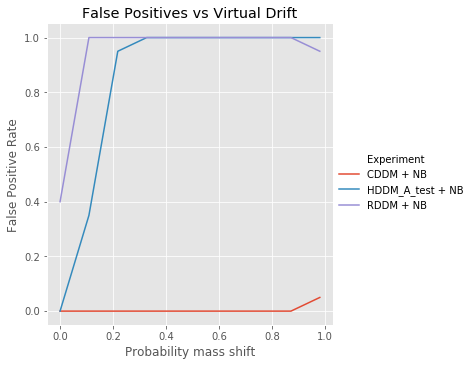

In [352]:
# Create plot
g = sns.relplot(x='Parameter', y='Outcome', hue='Experiment', kind='line', data=vd_fps)
g.set(xlabel='Probability mass shift', ylabel='False Positive Rate', title='False Positives vs Virtual Drift');
plt.savefig('virtual_drift_plt.png')

# Old Experiments

In [159]:
detectors = ['CDDM', 'HDDM_A_test', 'RDDM']
models = ['NaiveBayes2']
rates = [0.5, 0.5]

def high_noise_experiment(epsilon, repeats=10):
    probs = [0.5-epsilon, 0.5+epsilon, 0.5-epsilon, 0.5+epsilon]
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for i in range(repeats):
        for detector in detectors:
            for model in models:
                exp = Experiment(probs, detector, model, rates, epsilon)
                exp.run_experiment()
                results = results.append(exp.get_result_row())
    return results

def high_noise_experiments(repeats=10):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.5, num=10):
        results = results.append(high_noise_experiment(epsilon, repeats))
    return results

high_noise = high_noise_experiments()

In [172]:
high_noise.head()

,Experiment,Outcome,Parameter
0,CDDM + NaiveBayes2,None,0.0
0,HDDM_A_test + NaiveBayes2,None,0.0
0,RDDM + NaiveBayes2,None,0.0
0,CDDM + NaiveBayes2,None,0.0
0,HDDM_A_test + NaiveBayes2,None,0.0


In [169]:
high_noise.Parameter.unique()

array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
       0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ])

In [188]:
def get_fp_data(data):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    i = 1
    for exp in data.Experiment.unique():
        for param in data.Parameter.unique():
            results_i = data[(data['Experiment']==exp) & (data['Parameter']==param)]
            if len(results_i)==0:
                continue
            detection_rate = len([i for i in results_i['Outcome'] if i])/len(results_i)
            results.loc[i, :] = [exp, param, detection_rate]
            i += 1
    return results

In [189]:
high_noise_fp = get_fp_data(high_noise)
high_noise_fp.head()

,Experiment,Parameter,Outcome
1,CDDM + NaiveBayes2,0,0
2,CDDM + NaiveBayes2,0.0555556,0
3,CDDM + NaiveBayes2,0.111111,0
4,CDDM + NaiveBayes2,0.166667,0
5,CDDM + NaiveBayes2,0.222222,0


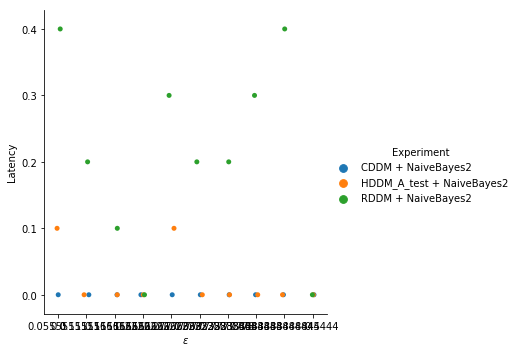

In [192]:
high_noise_fp['Experiment'] = high_noise_fp['Experiment'].astype('category')
g = sns.catplot(x='Parameter', y='Outcome', hue='Experiment', data=high_noise_fp)
g.set_axis_labels('$\epsilon$', 'Latency')
# g.ax.set_xticks(np.arange(0, 0.6, step=0.1));

In [194]:
import matplotlib.pyplot as plt

AttributeError: Unknown property group

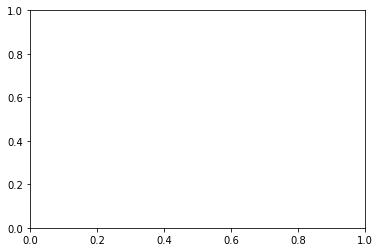

In [198]:
plt.plot(high_noise_fp.Parameter, high_noise_fp.Outcome, group=high_noise_fp.Experiment)

In [368]:
# Detection latency for high confidence
probs = [0.9, 0.1, 0.1, 0.9]


detectors = ['CDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models)

exp.run_experiments()
exp.results_table()

[30]
[17]
[9]
[1]


,Experiment,Latency,Detection Rate
0,SimpleModel + CDDM,30.0,1.0
1,SimpleModel + HDDM_A_test,17.0,1.0
2,SimpleModel + RDDM,9.0,1.0
3,SimpleModel + DDM,1.0,1.0


In [364]:
# False positives with high noise
probs = [0.55, 0.45, 0.55, 0.45]

detectors = ['EpDDM2.EpDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models)

exp.run_experiments()
exp.results_table()

[None]
[None]
[470]
[None]


,Experiment,Latency,Detection Rate
0,SimpleModel + EpDDM2.EpDDM,NaN,0.0
1,SimpleModel + HDDM_A_test,NaN,0.0
2,SimpleModel + RDDM,470.0,1.0
3,SimpleModel + DDM,NaN,0.0


In [316]:
# virtual drift masking real drift
probs = [1, 0.5, 1, 0.5]
rates = [0.01, 0.99]

detectors = ['EpDDM2.EpDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models, rates)

exp.run_experiments()
exp.results_table()

,Experiment,Latency,Detection Rate
0,SimpleModel + EpDDM2.EpDDM,NaN,0.0
1,SimpleModel + HDDM_A_test,15.5,1.0
2,SimpleModel + RDDM,48.0,0.9
3,SimpleModel + DDM,2.0,0.2


They have three common parameters: the confidence values
170 for drifts (αD =0.001) and warnings (αW =0.005), and the direction of the error, which can be one-sided (t=0, only
increments), default for HDDMW , or two-sided (t=1, error increments and decrements), and default for HDDMA.
Finally, HDDMW has an extra parameter (λ=0.05) that is used to control how much weight is given to more recent
data in comparison to older data.

In [96]:
# Test
from data_structures.attribute_scheme import AttributeScheme
from classifier.__init__ import *
from drift_detection.__init__ import *
from filters.project_creator import Project
from graphic.hex_colors import Color
from streams.readers.arff_reader import ARFFReader
from tasks.prequential_learner_detector_pairs import PrequentialMultiPairs

def run_tornado_experiment(dataset_name):
    
    # 1. Creating a project
    project = Project("projects/multi", dataset_name)

    # 2. Loading an arff file
    labels, attributes, stream_records = ARFFReader.read(tornado_path + f"/data_streams/{dataset_name}_n_0.1/{dataset_name}_n_0.1_101.arff")
    attributes_scheme = AttributeScheme.get_scheme(attributes)

    # 3. Initializing a Classifier-Detector Pairs
    NaiveBayes(labels, attributes_scheme['nominal']) # TODO: does this line need to be here?
    pairs = [
             [NaiveBayes(labels, attributes_scheme['nominal']), CDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), RDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), HDDM_A_test()],
             [Perceptron(labels, attributes_scheme['numeric']), CDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), RDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), HDDM_A_test()]
            ]

    # 4. Creating a color set for plotting results
    colors = [Color.Indigo[1], Color.Blue[1], Color.Green[1], Color.Lime[1], Color.Yellow[1],
              Color.Amber[1], Color.Orange[1]][:len(pairs)]

    # 5. Defining actual locations of drifts, acceptance delay interval, and vector of weights
    actual_drift_points = [20000, 40000, 60000, 80000]
    drift_acceptance_interval = 250
    w_vec = [1, 1, 1, 1, 1, 1]

    # 6. Creating a Prequential Evaluation Process
    prequential = PrequentialMultiPairs(pairs, attributes, attributes_scheme,
                                        actual_drift_points, drift_acceptance_interval,
                                        w_vec, project, color_set=colors, legend_param=False)

    prequential.run(stream_records, 1)

The project path "projects/multi/sine1_w_50/20200203_112227/" is created.
NB + CDDM [0.0, 32.384, 502.92522108429694] [323, [80086, 4], 0, 0, 6.872, 26408.898005072842]
NB + RDDM [0.1426, 32.624, 586.2231042447092] [410, [80119, 4], 0, 0, 64.048, 114.411597893195]
NB + HDDM.A.test [0.1425, 32.624, 561.2747091472556] [213, [80046, 4], 1, 0, 1.312, 399.2994229411124]
PR + CDDM [0.0, 7.144, 261.35836894172826] [243, [80061, 4], 0, 0, 6.872, 26623.39278903164]
PR + RDDM [0.1253, 7.384, 357.51938744215295] [410, [80107, 4], 0, 0, 64.0, 105.89123392128386]
PR + HDDM.A.test [0.1257, 7.384, 307.4328950351628] [228, [80037, 4], 0, 0, 1.248, 394.2944059963338]
THE END



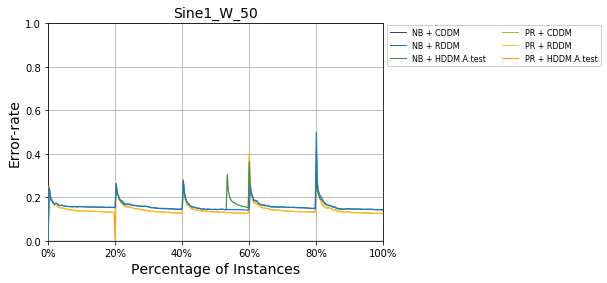

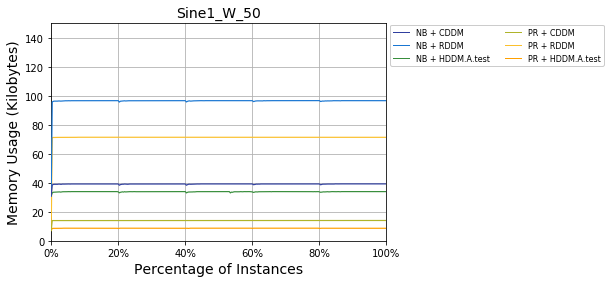

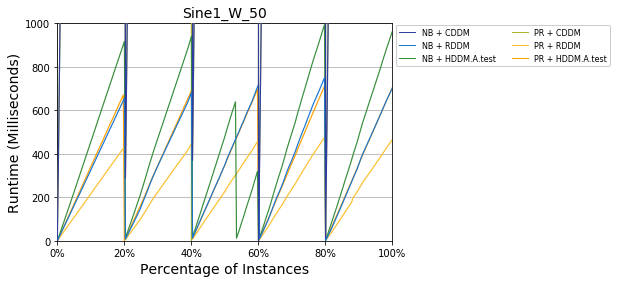

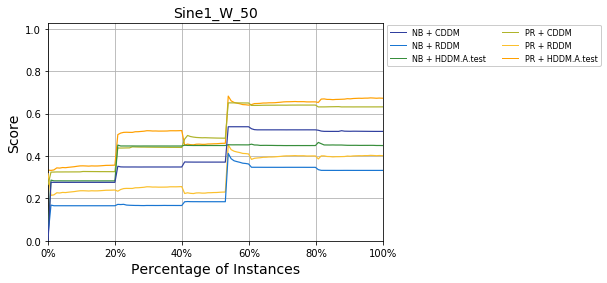

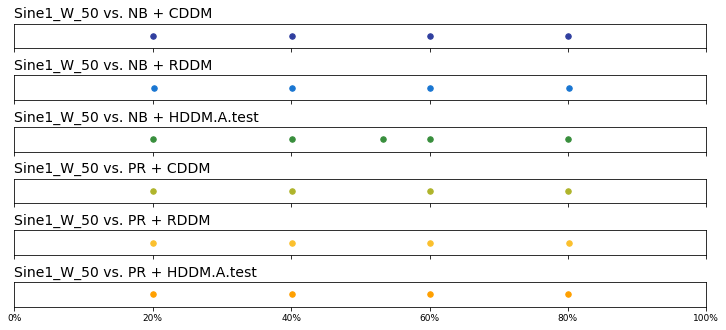

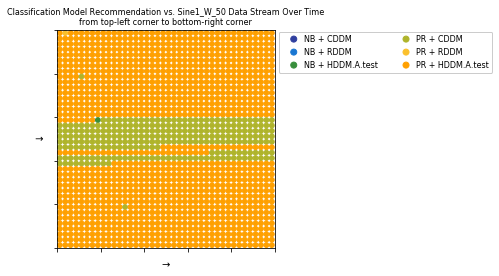

In [97]:
run_tornado_experiment('sine1_w_50')

The project path "projects/multi/circles_w_500/20200203_112801/" is created.
NB + CDDM [0.0, 32.32, 2678.276779508451] [1000, [0, 0], 0, 4, 6.872, 132965.25349503645]
NB + RDDM [0.1286, 32.592, 740.3044800448697] [1000, [0, 0], 3, 4, 64.048, 145.23966761043994]
NB + HDDM.A.test [0.1289, 32.624, 704.4924198526132] [1000, [0, 0], 5, 4, 1.312, 495.74628410482546]
PR + CDDM [0.0, 7.08, 1346.2911433562113] [1000, [0, 0], 0, 4, 6.872, 133327.05213402005]
PR + RDDM [0.3075, 7.384, 632.6641632549581] [910, [40161, 1], 6, 3, 64.048, 194.18797070466098]
PR + HDDM.A.test [0.2533, 7.384, 249.49792693951167] [1000, [0, 0], 4, 4, 1.312, 318.73827625531703]
THE END



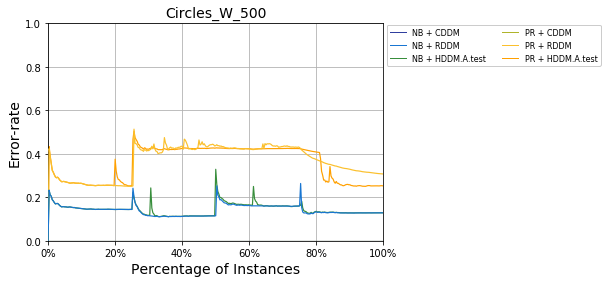

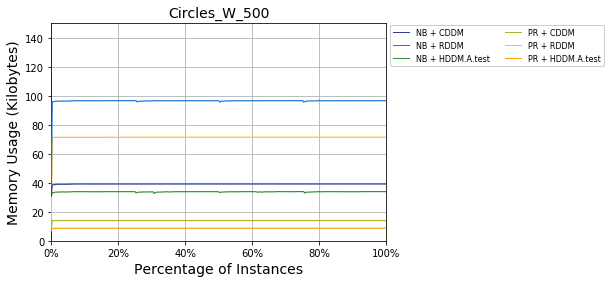

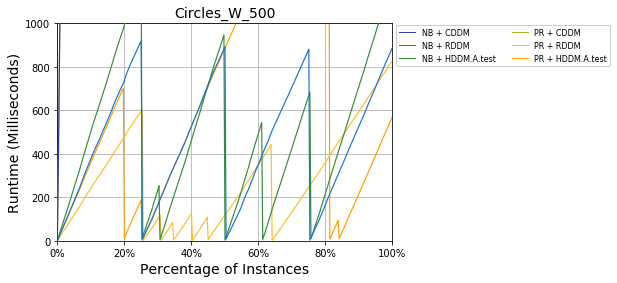

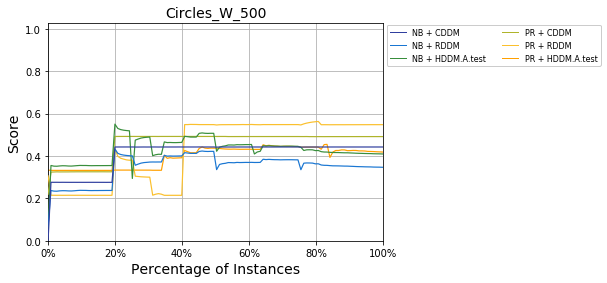

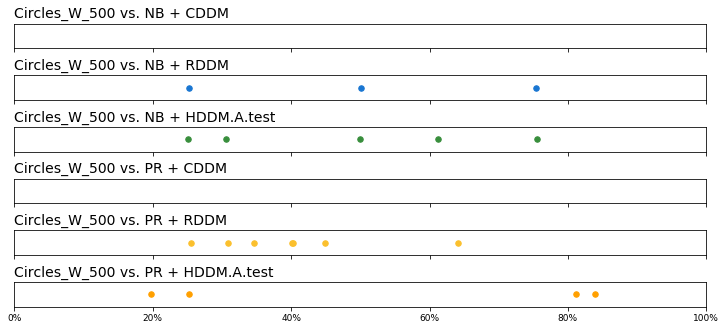

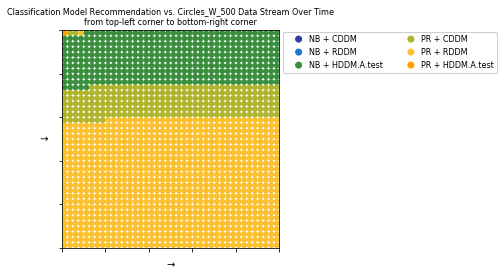

In [98]:
run_tornado_experiment('circles_w_500')

The project path "projects/multi/mixed_w_50/20200203_113339/" is created.
NB + CDDM [0.0, 39.168, 580.7655459102534] [350, [80084, 4], 0, 0, 6.872, 25901.953229913488]
NB + RDDM [0.134, 39.408, 669.5431970074424] [418, [80106, 4], 0, 0, 64.048, 111.45992368255975]
NB + HDDM.A.test [0.1338, 39.408, 665.5191095742339] [335, [80057, 4], 1, 0, 1.312, 395.5620308406651]
PR + CDDM [0.0, 8.92, 298.68043214446516] [306, [80065, 4], 0, 0, 6.872, 26236.86989910493]
PR + RDDM [0.1805, 9.192, 400.11455194689916] [500, [80141, 4], 0, 0, 64.048, 103.14123804346309]
PR + HDDM.A.test [0.1807, 9.192, 369.8395421015448] [413, [80058, 4], 0, 0, 1.312, 388.3358059429156]
THE END



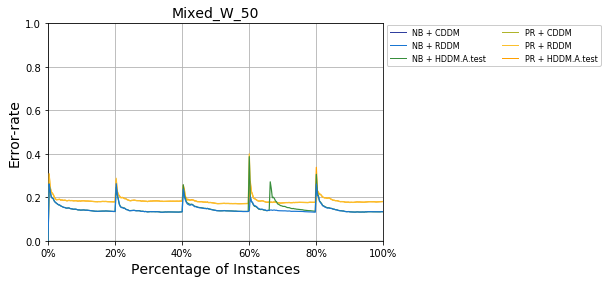

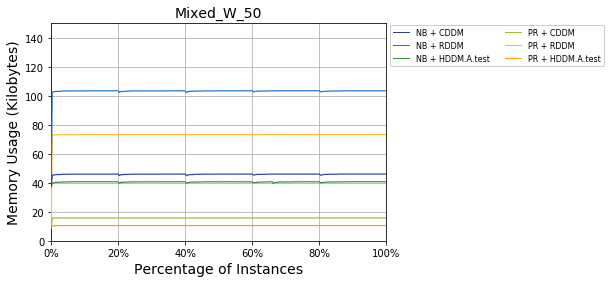

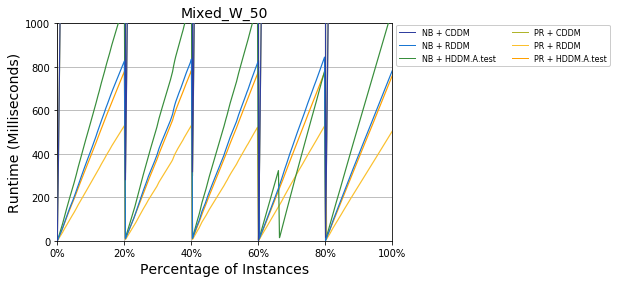

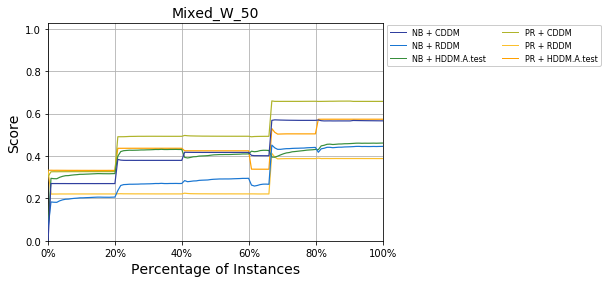

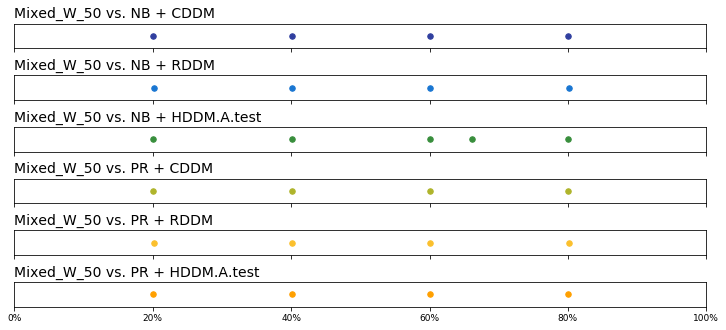

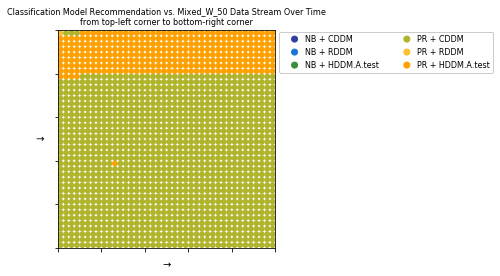

In [99]:
run_tornado_experiment('mixed_w_50')

The project path "projects/multi/led_w_500/20200203_115246/" is created.
NB + CDDM [0.0, 171.44, 24546.1271807726] [1000, [0, 0], 0, 4, 6.872, 132943.06789471375]
NB + RDDM [0.1055, 173.128, 7246.895563999715] [1000, [0, 0], 4, 4, 64.048, 148.6797447905701]
NB + HDDM.A.test [0.1054, 173.16, 7732.845085847657] [1000, [0, 0], 3, 4, 1.312, 511.9157170593098]
PR + CDDM [0.0, 70.688, 15094.841230948077] [1000, [0, 0], 0, 4, 6.872, 131625.1947124838]
PR + RDDM [0.1134, 73.712, 5099.579364337842] [1000, [0, 0], 6, 4, 64.0, 140.4870119658881]
PR + HDDM.A.test [0.1142, 73.808, 5381.348152510327] [1000, [0, 0], 3, 4, 1.312, 498.03537477419013]
THE END



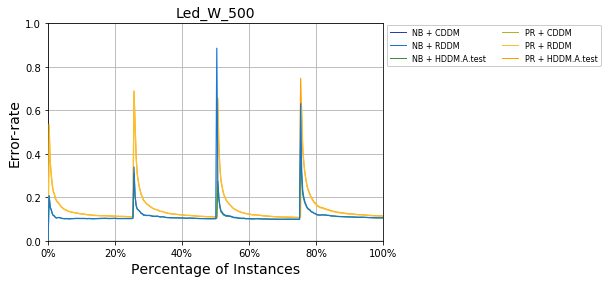

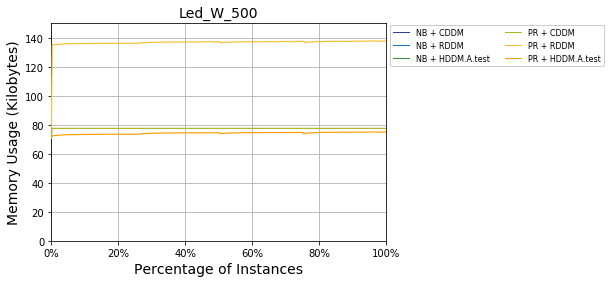

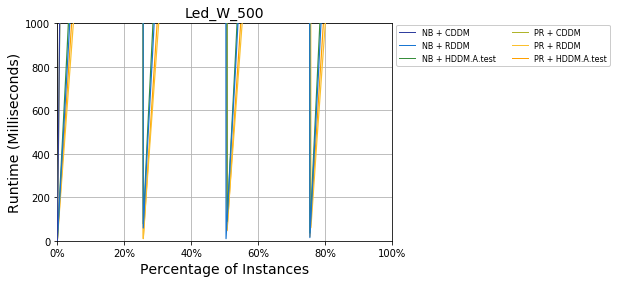

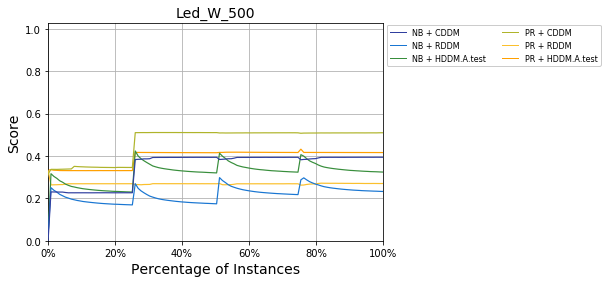

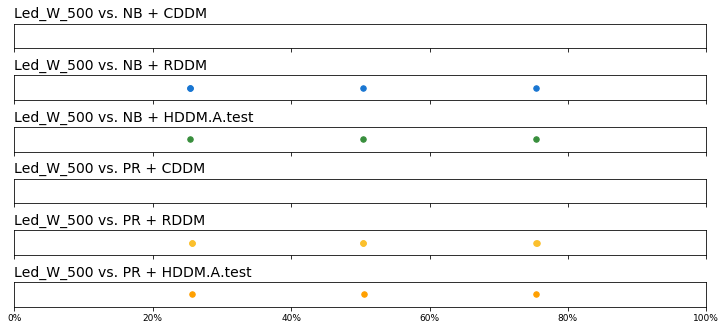

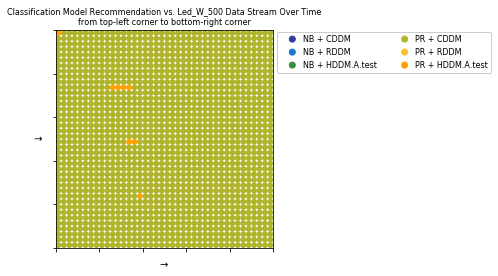

In [113]:
run_tornado_experiment('led_w_500')

In [149]:
def parse_results(path):
    path = os.path.abspath(path)
    dataset_name = re.match('^.*/(.*?).txt$', path).group(1)
    with open(path) as f:
        lines = f.read().split('\n')
    headers = lines[0].rstrip(']').lstrip('[')
    headers = [ header.lstrip() for header in headers.split(',') ]
    results = pd.DataFrame(columns=headers)
    i = 1
    for line in lines[1:]:
        fields = line.split('\t')
        if fields==['']:
            continue
        results.loc[i, :] = fields
        i += 1
        
    results['Dataset'] = dataset_name
        
    # Parse "Drift Detector Stats"
    total_delay = []
    tp = []
    location_of_last_detection = []
    fp, fn = [], []
    for i in range(len(results)):
        temp = eval(results.loc[i+1, 'Drift Detector Stats'])
        tdi, [lldi, tpi], fpi, fni = temp
        total_delay.append(tdi)
        tp.append(tpi)
        location_of_last_detection.append(lldi)
        fp.append(fpi)
        fn.append(fni)
    results['Total Delay'] = total_delay
    results['TP'] = tp
    results['FN'] = fn
    results['FP'] = fp
    
    # Split up name
    models = []
    detectors = []
    for i in range(len(results)):
        name = results.loc[i+1, 'Name']
        n_match = re.match('([\w\s]+) \+ ([\w\.]+)', name)
        models.append( n_match.group(1) )
        detectors.append( n_match.group(2) )
    results['Model'] = models
    results['Detector'] = detectors
    
    # Get wanted columns in right order
    results = results[['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Avg. Error-rate', 'Avg. Total Memory', 'Avg. Total Runtime', 'Total Delay']]
    results.columns = ['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Err-rate', 'Memory', 'Runtime', 'Total Delay']
        
    return results

In [151]:
experiments = ['sine1_w_50/20200203_112227', 'circles_w_500/20200203_112801', 'mixed_w_50/20200203_113339', 'led_w_500/20200203_115246']

results = pd.DataFrame(columns=['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Err-rate', 'Memory', 'Runtime', 'Total Delay'])
for experiment in experiments:

    dataset_name, exp_no = experiment.split('/')
    circles_path = f"./projects/multi/{dataset_name}/{exp_no}/{dataset_name}.txt"
    results_i = parse_results(circles_path)
#     results_i['Dataset'] = dataset_name
    results = results.append(results_i)
results

,Dataset,Detector,Model,TP,FN,FP,Err-rate,Memory,Runtime,Total Delay
1,sine1_w_50,CDDM,NAIVE BAYES,4,0,0,0.0,39.16,13528.19,323
2,sine1_w_50,RDDM,NAIVE BAYES,4,0,0,15.909999999999998,96.49,350.07,410
3,sine1_w_50,HDDM.A.test,NAIVE BAYES,4,0,1,16.14,33.86,433.49,213
4,sine1_w_50,CDDM,PERCEPTRON,4,0,0,0.0,13.97,13324.82,243
5,sine1_w_50,RDDM,PERCEPTRON,4,0,0,14.49,71.29,228.96,410
6,sine1_w_50,HDDM.A.test,PERCEPTRON,4,0,0,14.549999999999999,8.68,349.33,228
1,circles_w_500,CDDM,NAIVE BAYES,0,4,0,0.0,39.15,68062.33,1000
2,circles_w_500,RDDM,NAIVE BAYES,0,4,3,14.26,96.45,449.47,1000
3,circles_w_500,HDDM.A.test,NAIVE BAYES,0,4,5,14.52,33.81,481.73,1000
4,circles_w_500,CDDM,PERCEPTRON,0,4,0,0.0,13.94,67474.28,1000


In [153]:
print( results.to_latex(index=False) )

\begin{tabular}{llllllllll}
\toprule
       Dataset &     Detector &        Model & TP & FN & FP &            Err-rate &  Memory &   Runtime & Total Delay \\
\midrule
    sine1\_w\_50 &         CDDM &  NAIVE BAYES &  4 &  0 &  0 &                 0.0 &   39.16 &  13528.19 &         323 \\
    sine1\_w\_50 &         RDDM &  NAIVE BAYES &  4 &  0 &  0 &  15.909999999999998 &   96.49 &    350.07 &         410 \\
    sine1\_w\_50 &  HDDM.A.test &  NAIVE BAYES &  4 &  0 &  1 &               16.14 &   33.86 &    433.49 &         213 \\
    sine1\_w\_50 &         CDDM &   PERCEPTRON &  4 &  0 &  0 &                 0.0 &   13.97 &  13324.82 &         243 \\
    sine1\_w\_50 &         RDDM &   PERCEPTRON &  4 &  0 &  0 &               14.49 &   71.29 &    228.96 &         410 \\
    sine1\_w\_50 &  HDDM.A.test &   PERCEPTRON &  4 &  0 &  0 &  14.549999999999999 &    8.68 &    349.33 &         228 \\
 circles\_w\_500 &         CDDM &  NAIVE BAYES &  0 &  4 &  0 &                 0.0 &   39.15 &

# Post-hoc Tests

In [349]:
tornado_path = os.path.abspath('../scikit-posthocs')
sys.path.insert(0, tornado_path)
import scikit_posthocs as sp
import statsmodels.formula.api as sfa
import statsmodels.api as sa

In [345]:
results

,Dataset,Detector,Model,TP,FN,FP,Err-rate,Memory,Runtime,Total Delay
1,sine1_w_50,CDDM,NAIVE BAYES,4,0,0,0.0,39.16,13528.19,323
2,sine1_w_50,RDDM,NAIVE BAYES,4,0,0,15.909999999999998,96.49,350.07,410
3,sine1_w_50,HDDM.A.test,NAIVE BAYES,4,0,1,16.14,33.86,433.49,213
4,sine1_w_50,CDDM,PERCEPTRON,4,0,0,0.0,13.97,13324.82,243
5,sine1_w_50,RDDM,PERCEPTRON,4,0,0,14.49,71.29,228.96,410
6,sine1_w_50,HDDM.A.test,PERCEPTRON,4,0,0,14.549999999999999,8.68,349.33,228
1,circles_w_500,CDDM,NAIVE BAYES,0,4,0,0.0,39.15,68062.33,1000
2,circles_w_500,RDDM,NAIVE BAYES,0,4,3,14.26,96.45,449.47,1000
3,circles_w_500,HDDM.A.test,NAIVE BAYES,0,4,5,14.52,33.81,481.73,1000
4,circles_w_500,CDDM,PERCEPTRON,0,4,0,0.0,13.94,67474.28,1000


In [356]:
pc = sp.posthoc_nemenyi(results, val_col='Memory', group_col='Detector')

In [357]:
pc

,CDDM,HDDM.A.test,RDDM
CDDM,-1.000000,0.697567,0.506151
HDDM.A.test,0.697567,-1.000000,0.950614
RDDM,0.506151,0.950614,-1.000000


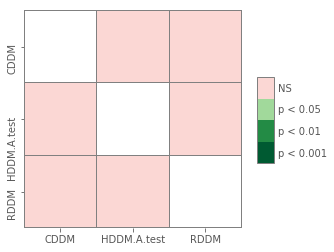

In [359]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args);

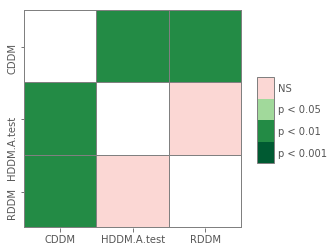

In [360]:
pc = sp.posthoc_nemenyi(results, val_col='Err-rate', group_col='Detector')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args);

In [361]:
pc

,CDDM,HDDM.A.test,RDDM
CDDM,-1.000000,0.001329,0.004623
HDDM.A.test,0.001329,-1.000000,0.937135
RDDM,0.004623,0.937135,-1.000000
